In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

# Get data

Read your personal API key

In [156]:
with open("../api_key", "r") as file:
    API_KEY = file.read()

In [157]:
# Define the API endpoint and parameters
url = "https://api.atmo-aura.fr/api/v1/valeurs/horaire"
params = {
    "api_token": API_KEY,
    "format": "json",
    "sites": "FR15038, FR15043, FR15039",
    "date_debut": "-2 years",
    "label_court_polluant": "PM2.5",
    "order_by_date": "asc",
}

# Make the GET request
response = requests.get(url, params=params)

response = json.loads(response.text)
data = pd.DataFrame(response["data"])

while response["links"]["next"] is not None:
    response = requests.get(response["links"]["next"])
    response = json.loads(response.text)
    data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S")
data["date"] = data["date"].dt.tz_localize(None)

In [158]:
data

,mesure_id,date,valeur,validation,site_id,type_appareil_id,type_appareil_label,code_polluant,label_polluant,id_poll_ue,label_court_polluant,label_unite,label_court_unite,unite,site_label
0,FR15038_39_57_3_C1,2022-11-18 16:00:00,2.753482,True,FR15038,57,Microcapteur (site fixe),39,"particules PM2,5",None,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
1,FR15038_39_11,2022-11-18 16:00:00,1.800000,True,FR15038,11,Analyseur Air,39,"particules PM2,5",6001,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
2,FR15038_39_11,2022-11-18 17:00:00,2.500000,True,FR15038,11,Analyseur Air,39,"particules PM2,5",6001,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
3,FR15038_39_57_3_C1,2022-11-18 17:00:00,3.468931,True,FR15038,57,Microcapteur (site fixe),39,"particules PM2,5",None,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
4,FR15038_39_57_3_C1,2022-11-18 18:00:00,6.296697,True,FR15038,57,Microcapteur (site fixe),39,"particules PM2,5",None,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26526,FR15038_39_11,2024-11-18 05:00:00,25.600000,True,FR15038,11,Analyseur Air,39,"particules PM2,5",6001,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
26527,FR15038_39_11,2024-11-18 06:00:00,23.800000,True,FR15038,11,Analyseur Air,39,"particules PM2,5",6001,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
26528,FR15038_39_11,2024-11-18 07:00:00,24.200000,True,FR15038,11,Analyseur Air,39,"particules PM2,5",6001,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères
26529,FR15038_39_11,2024-11-18 08:00:00,27.300000,True,FR15038,11,Analyseur Air,39,"particules PM2,5",6001,PM2.5,Microgramme par m3,microg/m3,µg/m³,St-Martin-d'Hères


In [ ]:
class site():
    def __init__(self, data, site_id):
        self.data = data[data["site_id"] == site_id]
        self.site_id = site_id

        self.reference_data = self.data[data["type_appareil_id"] == 11]
        self.reference_values = self.reference_data.loc[:, ["valeur", "date"]]

        self.microsensor_data = self.data[data["type_appareil_id"] == 57]
        self.microsensor_values = self.microsensor_data.loc[:, ["valeur", "date"]]

    def get_reference_data(self):
        return self.reference_data
    
    def get_microsensor_data(self):
        return self.microsensor_data
    
    def get_reference_values(self):
        return self.reference_values
    
    def get_microsensor_values(self):
        return self.microsensor_values

    def plot(self):
        x_ref = self.reference_values["date"]
        y_ref = self.reference_values["valeur"]

        x_micro = self.microsensor_values["date"]
        y_micro = self.microsensor_values["valeur"]

        plt.figure(figsize=(12, 6))
        plt.plot(x_ref, y_ref, label="Reference values")
        plt.plot(x_micro, y_micro, label="Microsensor values")
        plt.title(f"PM2.5 values for site {self.site_id}")
        plt.xlabel("Date")
        plt.ylabel("PM2.5 values (µg/m³)")
        plt.legend()
        plt.show()


In [179]:
site_id_dict = {
    "Saint Martin d'Hères": "FR15038",
    "Les Frenes": "FR15043",
    "Rocade Sud": "FR15039",
}

SMH = site(data, site_id_dict["Saint Martin d'Hères"])

In [180]:
SMH.get_microsensor_values()

,valeur,date
0,2.753482,2022-11-18 16:00:00
3,3.468931,2022-11-18 17:00:00
4,6.296697,2022-11-18 18:00:00
7,11.012331,2022-11-18 19:00:00
8,16.483171,2022-11-18 20:00:00
...,...,...
18816,11.810688,2023-12-31 19:00:00
18818,12.841020,2023-12-31 20:00:00
18819,18.968117,2023-12-31 21:00:00
18822,23.280900,2023-12-31 22:00:00


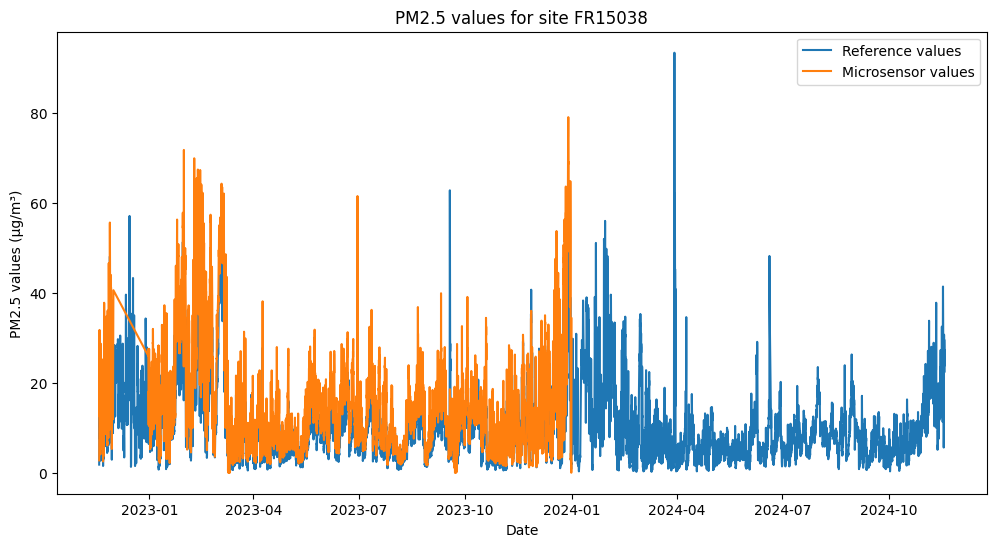

In [181]:
SMH.plot()